In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz
/kaggle/input/shelter-animal-outcomes/train.csv.gz
/kaggle/input/shelter-animal-outcomes/test.csv.gz


### Libraries

In [34]:
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

### Datasets

In [3]:
PATH = '/kaggle/input/shelter-animal-outcomes/'
train = pd.read_csv(PATH + 'train.csv.gz')
test = pd.read_csv(PATH + 'test.csv.gz')
sample_submission = pd.read_csv(PATH + 'sample_submission.csv.gz')

### Examine the Dataset

In [4]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


In [6]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [7]:
test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

### Lets fill the NaN values 

In [8]:
train.shape, test.shape

((26729, 10), (11456, 8))

In [9]:
test

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White
...,...,...,...,...,...,...,...,...
11451,11452,NaN,2014-07-08 14:50:00,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
11452,11453,NaN,2014-10-21 12:57:00,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue
11453,11454,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan


In [10]:
train.drop('Name', axis = 1, inplace = True)

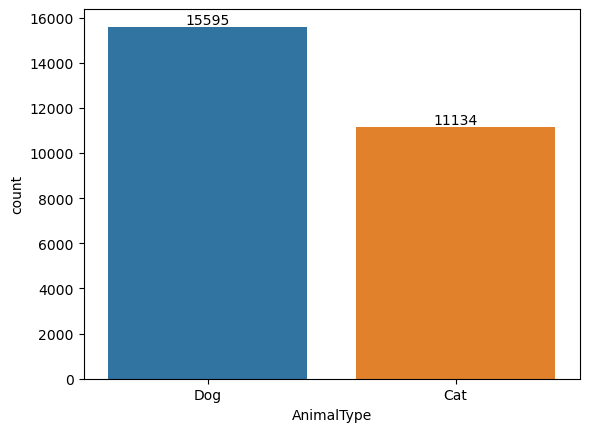

In [11]:
ax = sbn.countplot(x = train['AnimalType'])
ax.bar_label(ax.containers[0]);

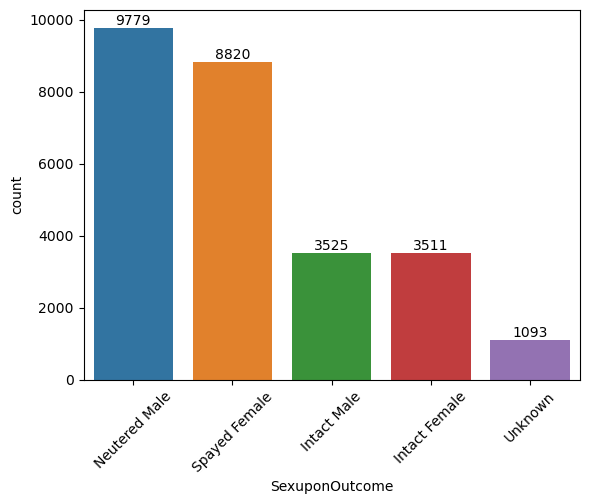

In [12]:
ax = sbn.countplot(x = train['SexuponOutcome'])
ax.bar_label(ax.containers[0]);
plt.xticks(rotation = 45);

In [13]:
train['Breed'].value_counts()

Domestic Shorthair Mix                 8810
Pit Bull Mix                           1906
Chihuahua Shorthair Mix                1766
Labrador Retriever Mix                 1363
Domestic Medium Hair Mix                839
                                       ... 
Shih Tzu/Dachshund                        1
Whippet/Shetland Sheepdog                 1
Patterdale Terr/Chihuahua Shorthair       1
Golden Retriever/Akita                    1
Boxer/German Shepherd                     1
Name: Breed, Length: 1380, dtype: int64

In [14]:
train['Breed'].nunique()

1380

In [15]:
del train['Breed']
del test['Breed']

In [16]:
train['Color'].nunique()

366

In [17]:
del train['Color']
del test['Color']

In [18]:
train.isnull().sum()

AnimalID              0
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
dtype: int64

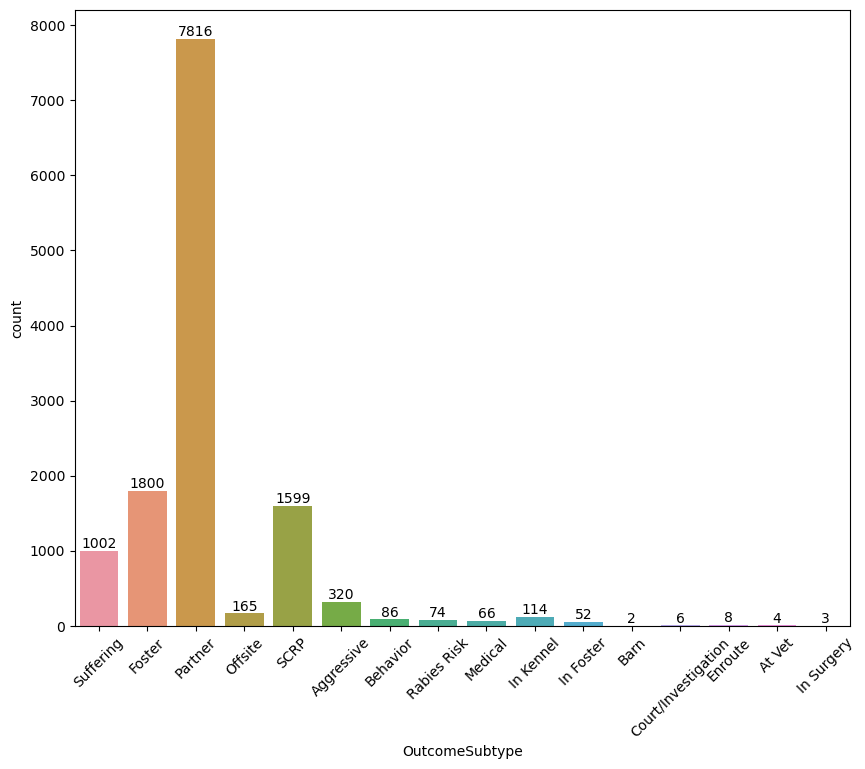

In [19]:
plt.figure(figsize = (10, 8))
ax = sbn.countplot(x = train['OutcomeSubtype'])
ax.bar_label(ax.containers[0]);
plt.xticks(rotation = 45);

In [20]:
train['OutcomeSubtype'] = train['OutcomeSubtype'].fillna(train['OutcomeSubtype'].mode()[0])
train

,AnimalID,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome
0,A671945,2014-02-12 18:22:00,Return_to_owner,Partner,Dog,Neutered Male,1 year
1,A656520,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year
2,A686464,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years
3,A683430,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks
4,A667013,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years
...,...,...,...,...,...,...,...
26724,A702446,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month
26725,A718934,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months
26726,A698128,2015-03-09 13:33:00,Adoption,Partner,Dog,Neutered Male,4 years
26727,A677478,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks


In [21]:
train['SexuponOutcome'] = train['SexuponOutcome'].fillna(train['SexuponOutcome'].mode()[0])


In [22]:
train['AgeuponOutcome'].value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [23]:
train['AgeuponOutcome'] = train['AgeuponOutcome'].fillna(train['AgeuponOutcome'].mode()[0])


In [24]:
for i in range(len(train['AgeuponOutcome'])):
    yas, birim = train['AgeuponOutcome'][i].split()
    if birim == 'weeks' or birim == 'week':
        yas = int(yas) * 7  
    elif birim == 'months' or birim == 'month':
        yas = int(yas) * 30  
    elif birim == 'years' or birim == 'year':
        yas = int(yas) * 365  
    train['AgeuponOutcome'][i] = yas

In [25]:
train.drop('AnimalID', axis = 1, inplace = True)

In [26]:
label = LabelEncoder()
train['OutcomeType'] = label.fit_transform(train['OutcomeType'])

In [27]:
train['DateTime'] = pd.to_datetime(train['DateTime'], format = '%Y-%m-%d')
train['Year'] = train['DateTime'].dt.year
train['Month'] = train['DateTime'].dt.month

In [28]:
del train['DateTime']

In [29]:
x = train.drop('OutcomeType', axis = 1)[:1000]
y = train['OutcomeType'][:1000]
x = pd.get_dummies(x, drop_first = True)

In [30]:
def classification(x, y):
    model2 = DecisionTreeClassifier()
    model3 = RandomForestClassifier()
    model4 = BernoulliNB()
    model5= GaussianNB()
    model6 = SVC()
    model7 = GradientBoostingClassifier()
    model8 = AdaBoostClassifier()
    model9 = HistGradientBoostingClassifier()
    model10 = BaggingClassifier()
    model11 = XGBClassifier()
    
    models = [model2, model3, model4, model5, model6, model7, model8, model9, model10, model11]
    model_names = ['Decision', 'Random', 'Bernoulli', 'Gaussian', 'Support', 'Gradient',
                  'AdaBoost', 'Hist', 'Bagging', 'XGBoost']
    
    x_train, x_test, y_train, y_true = train_test_split(x, y, test_size = 0.2, random_state = 42)
    x_train = StandardScaler().fit_transform(x_train)
    x_test = StandardScaler().fit_transform(x_test)
    # x_train = MinMaxScaler().fit_transform(x_train)
    # x_test = MinMaxScaler().fit_transform(x_test)
    
    acc = []
    #cnf_matrix = confusion_matrix()
    skor = pd.DataFrame(columns = ['Accuracy'], index = model_names)
    
    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        acc.append(accuracy_score(y_true, y_pred) * 100)
        
    skor['Accuracy'] = acc
                                   
    print(skor.sort_values('Accuracy', ascending = False))
        
    plt.figure(figsize=(10, 6))
    sbn.barplot(data = skor, y ='Accuracy', x = skor.index, color = 'lightblue')
    for i, v in enumerate(skor['Accuracy']):
        plt.text(i, v, str(round(v, 2)), color='black', ha='center')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Scores of Classification Models')
    plt.show()

           Accuracy
Support        68.5
Bernoulli      67.5
Gradient       66.5
Hist           64.0
XGBoost        64.0
Random         60.0
Bagging        58.5
Decision       58.0
Gaussian       50.0
AdaBoost       50.0


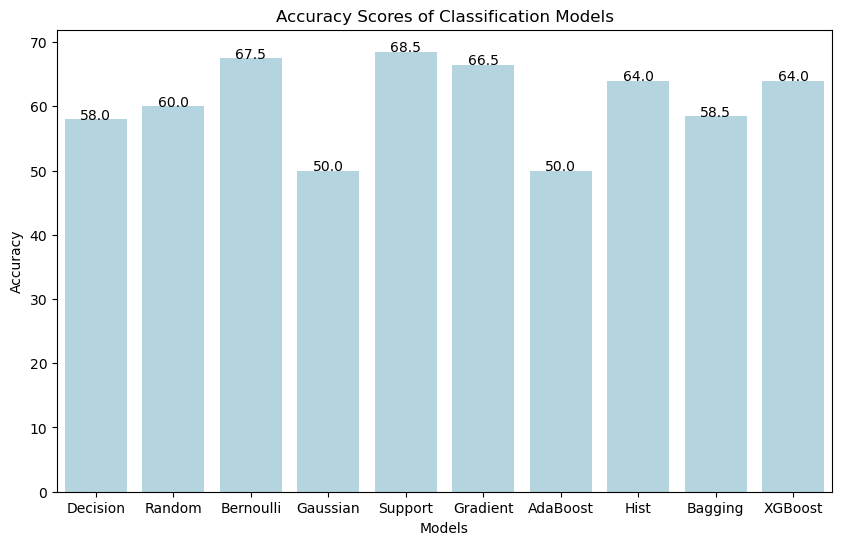

In [31]:
classification(x, y)

In [32]:
x_train, x_test, y_train, y_true = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [35]:
model = Sequential()
model.add(Dense(units = 65, activation = 'relu'))
model.add(Dense(units = 112, activation = 'relu'))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 10, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy') 

In [36]:
early = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max')

In [37]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_true), epochs = 100, batch_size = 32, verbose = 1, callbacks = [early])

Epoch 1/100
25/25 [==============================] - 5s 49ms/step - loss: 0.0000e+00 - accuracy: 0.0162 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0000e+00 - accuracy: 0.0050 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 0.0050 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 0.0050 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/100
25/25 [==============================] - 1s 30ms/step - loss: nan - accuracy: 0.1937 - val_loss: nan - val_accuracy: 0.3800
Epoch 6/100
25/25 [==============================] - 1s 29ms/step - loss: nan - accuracy: 0.4100 - val_loss: nan - val_accuracy: 0.3800
Epoch 7/100
25/25 [==============================] - 1s 29ms/step - loss: nan - accuracy: 0.4100 - val_loss: nan

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65)                3445      
                                                                 
 dense_1 (Dense)             (None, 112)               7392      
                                                                 
 dense_2 (Dense)             (None, 100)               11300     
                                                                 
 dense_3 (Dense)             (None, 128)               12928     
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               2

<Axes: >

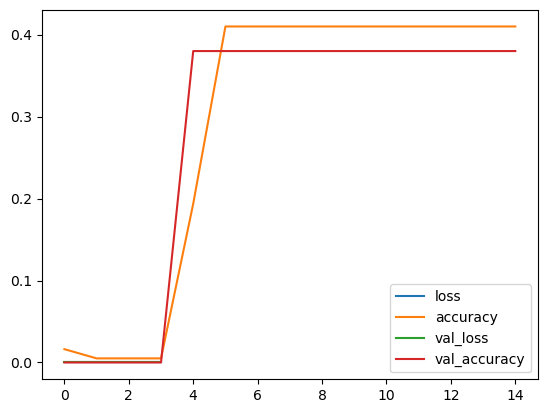

In [39]:
loss = pd.DataFrame(history.history)
loss.plot()